# Imports

In [1]:
try:
# %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np
from PIL import Image, ImageFont, ImageDraw
import os
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

# Load Data

In [2]:
def load_images_from_folder(folder_path):
    images = []
    labels = []
    for person_name in os.listdir(folder_path):
        person_path = os.path.join(folder_path, person_name)
        if os.path.isdir(person_path):
            for img_name in os.listdir(person_path):
                img_path = os.path.join(person_path, img_name)
                if img_path.endswith('.jpg'):  # Atur format gambar sesuai dataset
                    img = Image.open(img_path).resize((120, 120)) 
                    images.append(np.array(img) / 255.0)  # Normalisasi pixel ke [0, 1]
                    labels.append(person_name)
    return np.array(images), np.array(labels)

# Load dataset
images, labels = load_images_from_folder("dataset_siamese")


# Pairing Data

In [87]:
# def create_pairs(data):
#     positive_pairs = []
#     negative_pairs = []
#     labels = []  # 1 untuk pasangan positif, 0 untuk pasangan negatif

#     # Positive pairs
#     for person, images in data.items():
#         for i in range(len(images)):
#             for j in range(i + 1, len(images)):
#                 positive_pairs.append((images[i], images[j]))
#                 labels.append(1)

#     # Negative pairs
#     persons = list(data.keys())
#     for i in range(len(persons)):
#         for j in range(i + 1, len(persons)):
#             person1_images = data[persons[i]]
#             person2_images = data[persons[j]]
#             for img1 in person1_images:
#                 for img2 in person2_images:
#                     negative_pairs.append((img1, img2))
#                     labels.append(0)

#     # Gabungkan pasangan positif dan negatif
#     pairs = positive_pairs + negative_pairs
#     return pairs, labels

# pairs, labels = create_pairs(data)
# print(f"Total pairs: {len(pairs)}")

In [3]:
def create_pairs(images, labels):
    """
    Membuat pasangan positif dan negatif untuk face recognition.
    """
    pairs = []
    pair_labels = []
    n_classes = len(np.unique(labels))  # Jumlah identitas unik
    identity_indices = {label: np.where(labels == label)[0] for label in np.unique(labels)}
    
    for label in identity_indices:
        indices = identity_indices[label]
        n_samples = len(indices) - 1
        
        for i in range(n_samples):
            # Pair positif
            z1, z2 = indices[i], indices[i + 1]
            pairs.append([images[z1], images[z2]])
            pair_labels.append(1)
            
            # Pair negatif
            other_label = random.choice([l for l in identity_indices if l != label])
            z1 = indices[i]
            z2 = random.choice(identity_indices[other_label])
            pairs.append([images[z1], images[z2]])
            pair_labels.append(0)
            
    return np.array(pairs), np.array(pair_labels).astype('float32')


In [4]:
# Membuat pasangan
pairs, pair_labels = create_pairs(images, labels)

# Contoh bentuk data
print("Shape of pairs:", pairs.shape)  # (N, 2, height, width, channels)
print("Shape of labels:", pair_labels.shape)  # (N,)


Shape of pairs: (124, 2, 120, 120, 3)
Shape of labels: (124,)


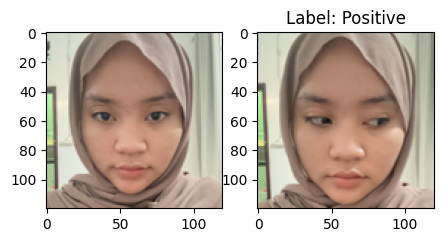

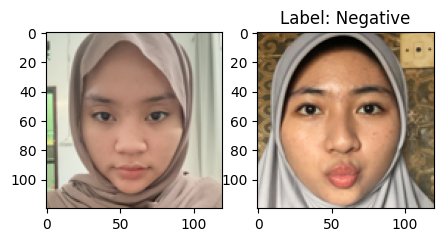

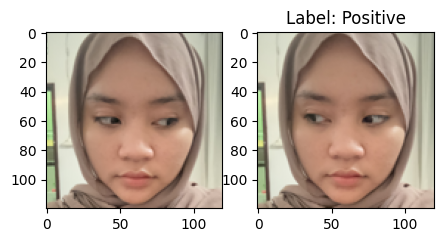

In [5]:
def show_pair(pair, label):
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    axes[0].imshow(pair[0])
    axes[1].imshow(pair[1])
    plt.title(f"Label: {'Positive' if label == 1 else 'Negative'}")
    plt.show()

# Tampilkan contoh pasangan
for i in range(3):
    show_pair(pairs[i], pair_labels[i])


# Image Preprocessing

In [7]:


# Split data menjadi training dan testing
train_pairs, test_pairs, train_labels, test_labels = train_test_split(pairs, pair_labels, test_size=0.3, random_state=42)

print(f"Train pairs: {len(train_pairs)}, Test pairs: {len(test_pairs)}")


Train pairs: 86, Test pairs: 38


In [8]:
train_pairs = train_pairs.astype('float32')
test_pairs = test_pairs.astype('float32')

# Building Model

In [9]:
# # BUILD THE MODEL WITHOUT CNN
# def initialize_base_network():
#     input = Input(shape=(80,80,3), name="base_input")
#     x = Flatten(name="flatten_input")(input)
#     x = Dense(128, activation='relu', name="first_base_dense")(x)
#     x = Dropout(0.1, name="first_dropout")(x)
#     x = Dense(128, activation='relu', name="second_base_dense")(x)
#     x = Dropout(0.1, name="second_dropout")(x)
#     x = Dense(128, activation='relu', name="third_base_dense")(x)

#     return Model(inputs=input, outputs=x)

In [10]:
# BUILD THE MODEL WITH CNN
def initialize_base_network():
    input = Input(shape=(120,120,3), name="base_input")
    # first cnn layer
    x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(2e-4))(input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)

    #second cnn layer
    x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(2e-4))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)

    #third cnn layer
    x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(2e-4))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)

    x = Flatten(name="flatten_input")(x)
    x = Dense(512, activation='sigmoid', kernel_regularizer=regularizers.l2(2e-3), name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)

    return Model(inputs=input, outputs=x)

In [11]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [12]:
# create the left input and point to the base network
base_network = initialize_base_network()
input_a = Input(shape=(120,120,3), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(120,120,3), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ left_input          │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right_input         │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 512)       │ 11,169,344 │ left_input[0][0], │
│ (Functional)        │                   │            │ right_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1)         │          0 │ functional[0][0], │
│ (Lambda)            │                   │            │ functional[1][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,169,344 (42.61 MB)

 Trainable params: 11,169,344 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [14]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [15]:
optimizer = Adam(learning_rate=1e-3)
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=optimizer)
history = model.fit([train_pairs[:,0], train_pairs[:,1]], train_labels, epochs=100, batch_size=32, validation_data=([test_pairs[:,0], test_pairs[:,1]], test_labels))

Epoch 1/100


c:\Users\wahyu melinda p\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['left_input', 'right_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 798ms/step - loss: 11.2900 - val_loss: 2.2064
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 476ms/step - loss: 2.4373 - val_loss: 2.2369
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 537ms/step - loss: 2.3734 - val_loss: 2.2523
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 492ms/step - loss: 2.3830 - val_loss: 2.2463
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 512ms/step - loss: 2.3033 - val_loss: 2.2259
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step - loss: 2.2905 - val_loss: 2.1962
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 519ms/step - loss: 2.2522 - val_loss: 2.1610
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 484ms/step - loss: 2.2168 - val_loss: 2.1191
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 469ms/step - loss: 2.1545 - val_loss: 2.0692
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step - loss: 2.1108 - val_loss: 2.0115
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 573ms/step - loss: 1.9960 - val_loss: 1.9539
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 441ms/step - loss: 1.9595 - val_l

# Model Evaluation

In [16]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [17]:
loss = model.evaluate(x=[test_pairs[:,0],test_pairs[:,1]], y=test_labels)

y_pred_train = model.predict([train_pairs[:,0], train_pairs[:,1]])
train_accuracy = compute_accuracy(train_labels, y_pred_train)

y_pred_test = model.predict([test_pairs[:,0], test_pairs[:,1]])
test_accuracy = compute_accuracy(test_labels, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2039 
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 
Loss = 0.2086019068956375, Train Accuracy = 0.9767441860465116 Test Accuracy = 0.9736842105263158


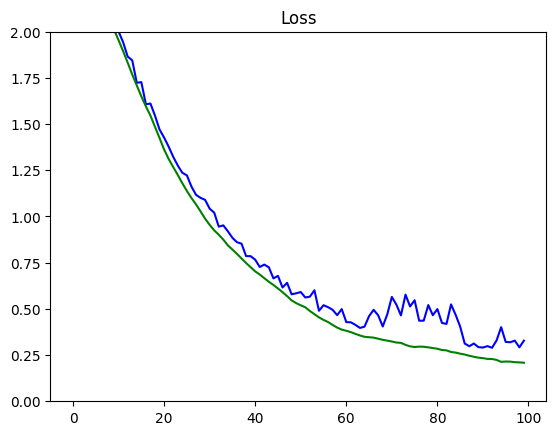

In [18]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=2)

In [19]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 120,120,3])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [120, 120*n,3])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([120*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 120,120,3])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [120, 120*n,3])
    plt.imshow(right)



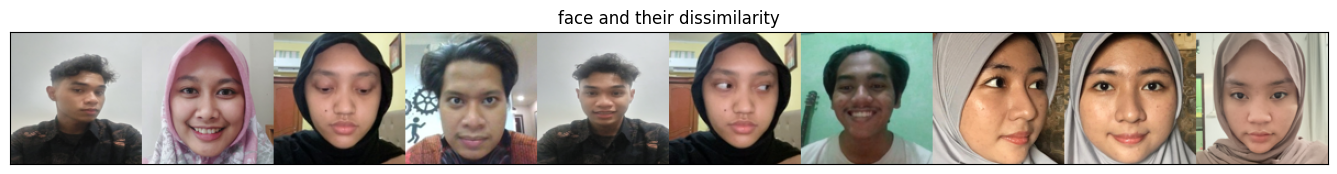

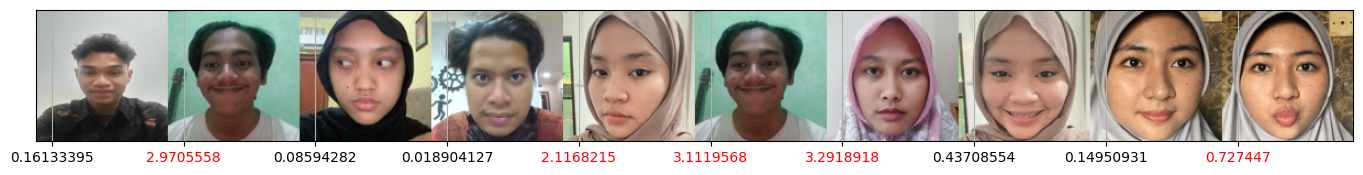

In [20]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(train_pairs[:, 0][indexes], train_pairs[:, 1][indexes], y_pred_train[indexes], train_labels[indexes], "face and their dissimilarity",10)

In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ left_input          │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right_input         │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 512)       │ 11,169,344 │ left_input[0][0], │
│ (Functional)        │                   │            │ right_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1)         │          0 │ functional[0][0], │
│ (Lambda)            │                   │            │ functional[1][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,508,034 (127.82 MB)

 Trainable params: 11,169,344 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,338,690 (85.22 MB)

In [22]:
def preprocess_images(image_path_1, image_path_2, target_size):
    """
    Fungsi untuk memuat dan memproses dua gambar.
    """
    # Proses gambar pertama
    img1 = load_img(image_path_1, target_size=target_size)
    img_array_1 = img_to_array(img1) / 255.0
    img_array_1 = np.expand_dims(img_array_1, axis=0)

    # Proses gambar kedua
    img2 = load_img(image_path_2, target_size=target_size)
    img_array_2 = img_to_array(img2) / 255.0
    img_array_2 = np.expand_dims(img_array_2, axis=0)

    return img_array_1, img_array_2


In [23]:
def predict_siamese(model, image_path_1, image_path_2, target_size=(120, 120)):
    """
    Fungsi untuk memproses dua gambar dan menghasilkan prediksi dari model Siamese.
    """
    # Preproses kedua gambar
    img_array_1, img_array_2 = preprocess_images(image_path_1, image_path_2, target_size)

    # Lakukan prediksi dengan dua input
    prediction = model.predict([img_array_1, img_array_2])

    # Cetak hasil prediksi
    print("Hasil prediksi (kemiripan):", prediction)

    # Tampilkan kedua gambar
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(load_img(image_path_1, target_size=target_size))
    plt.axis("off")
    plt.title("Gambar 1")

    plt.subplot(1, 2, 2)
    plt.imshow(load_img(image_path_2, target_size=target_size))
    plt.axis("off")
    plt.title("Gambar 2")

    plt.suptitle(f"Prediction (similarity): {prediction[0][0]:.2f}")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Hasil prediksi (kemiripan): [[0.72533065]]


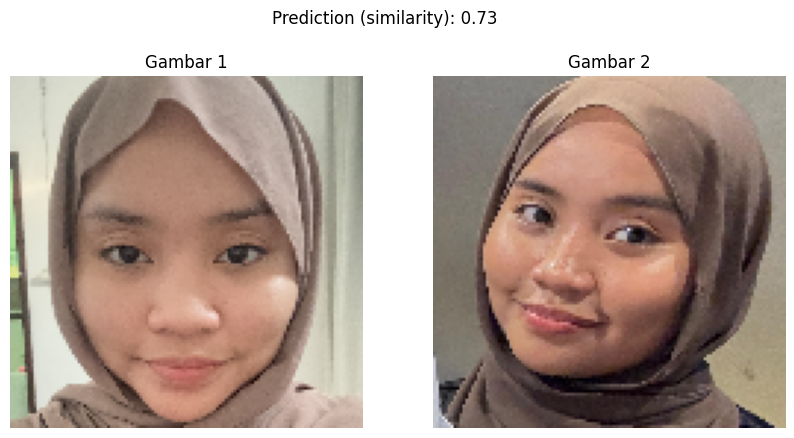

In [63]:
# image_path_1 = "C:/Users/wahyu melinda p/Downloads/codingan_aden/dataset_siamese/melin/1.jpg"
# # image_path_2 = "C:/Users/wahyu melinda p/Downloads/codingan_aden/dataset_siamese/aden/5.jpg"
# image_path_2 = "C:/Users/wahyu melinda p/Downloads/melin/val_melin-09.jpg"

# predict_siamese(model, image_path_1, image_path_2)

image_path_1 = "C:/Users/wahyu melinda p/Downloads/codingan_aden/dataset_siamese/aden/9.jpg"
image_path_2 = "C:/Users/wahyu melinda p/Downloads/aden/val_aden-10.jpg"

predict_siamese(model, image_path_1, image_path_2)


In [39]:
model.save('siamese_model_bestAccuracy.h5')  # Menyimpan model dalam format H5

In [40]:
model.save('siamese_model_bestAccuracy.keras')  # Menyimpan model dalam format H5

In [71]:
import tensorflow as tf

# Fungsi untuk representative dataset
# def representative_dataset():
#     # Contoh: Ganti `dataset` dengan dataset Anda
#     for input_value in dataset_siamese.take(100):  # Ambil 100 sampel dari dataset
#         # Pastikan input_value memiliki bentuk yang sama dengan input model
#         yield [tf.cast(input_value, tf.float32)]

# Load model dari file HDF5
model = tf.keras.models.load_model(
    "siamese_model_bestAccuracy.h5", 
    custom_objects={
        "eucl_dist_output_shape": eucl_dist_output_shape,
        "euclidean_distance": euclidean_distance  # Tambahkan fungsi kustom lain jika ada
    },
    compile=False  # Nonaktifkan kompilasi

)

# Konversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optimasi INT8 dengan representative dataset
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = representative_dataset
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8  # Input type INT8
# converter.inference_output_type = tf.int8  # Output type INT8

# Konversi model
tflite_model = converter.convert()

# Simpan model TFLite INT8 ke file
with open("model_int8_quantized.tflite", "wb") as f:
    f.write(tflite_model)

print("Model INT8 berhasil dikonversi dan disimpan sebagai model_int8_quantized.tflite!")

INFO:tensorflow:Assets written to: C:\Users\WAHYUM~1\AppData\Local\Temp\tmpwqmm88ru\assets


INFO:tensorflow:Assets written to: C:\Users\WAHYUM~1\AppData\Local\Temp\tmpwqmm88ru\assets


Saved artifact at 'C:\Users\WAHYUM~1\AppData\Local\Temp\tmpwqmm88ru'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name='left_input'), TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name='right_input')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2249831206576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249831203584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249831208336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249831204464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249831210096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249831206752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249831208160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2249831210448: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model INT8 berhasil dikonversi dan disimpan sebagai model_i